# Step 1: Install Dependencies

This cell will install `spaCy` (our lightweight NLP library) and its small English model. This is much faster and more reliable than the Java-based tool.

In [1]:
!pip install spacy
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 54.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


# Step 2: Upload Your Data

Use the 'Files' icon on the left-hand sidebar to upload your `reddit_climate_data.csv` file. You must do this *before* running Step 3.



# Step 3: Run the Full Report Generation Script (Using spaCy)

This single cell will run both Part 1 (Concept Extraction) and Part 2 (Triple Extraction).

It will:
1.  **Print** the "Top 10" tables for your report (Tables 4.1, 4.2, 4.3, 4.4).
2.  **Save four CSV files** containing *all* the extracted data (`reddit_unigrams_all.csv`, `reddit_bigrams_all.csv`, `reddit_trigrams_all.csv`, `reddit_triples_all.csv`).

In [1]:
import pandas as pd
import re
from collections import Counter
import sys
import spacy

# Load the spaCy model
try:
    nlp = spacy.load("en_core_web_sm")
    print("spaCy model 'en_core_web_sm' loaded successfully.")
except IOError:
    print("Error: spaCy model not found. Please re-run the install cell (Step 1).")
    nlp = None

# --- Part 1: Concept Extraction (for Sec 4.2) ---

CUSTOM_STOPWORDS = set([
    'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours',
    'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers',
    'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves',
    'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are',
    'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does',
    'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until',
    'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into',
    'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down',
    'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here',
    'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',
    'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so',
    'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now', 've',
    'll', 're', 'm', 'www', 'https', 'com', 'http', 'climate', 'change'
])

def clean_text_for_concepts(text):
    if pd.isna(text):
        return []
    text = str(text).lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    words = text.split()
    return [word for word in words if word not in CUSTOM_STOPWORDS and len(word) > 2]

def get_ngrams(word_list, n):
    return [" ".join(word_list[i:i+n]) for i in range(len(word_list) - n + 1)]

def extract_concepts(filename):
    print("Running Concept Extraction (for Tables 4.1, 4.2, 4.3)...")
    try:
        df = pd.read_csv(filename)
    except FileNotFoundError:
        print(f"Error: File '{filename}' not found.")
        print("Please upload your file using the 'Files' icon on the left.")
        return None

    data = df['text'].dropna()
    all_words, all_bigrams, all_trigrams = [], [], []

    for text in data:
        words = clean_text_for_concepts(text)
        all_words.extend(words)
        all_bigrams.extend(get_ngrams(words, 2))
        all_trigrams.extend(get_ngrams(words, 3))

    unigram_counts = Counter(all_words)
    bigram_counts = Counter(all_bigrams)
    trigram_counts = Counter(all_trigrams)

    # --- Print Markdown Tables for the Report ---
    print("\n4.2.1. Table 4.1: Top 10 Unigrams (Main Topics)")
    print("| Concept | Frequency |")
    print("| :--- | :--- |")
    for concept, freq in unigram_counts.most_common(10):
        print(f"| {concept} | {freq} |")

    print("\n4.2.2. Table 4.2: Top 10 Bigrams (Keyphrases)")
    print("| Concept | Frequency |")
    print("| :--- | :--- |")
    for concept, freq in bigram_counts.most_common(10):
        print(f"| {concept} | {freq} |")

    print("\n4.2.3. Table 4.3: Top 10 Trigrams (Main Themes)")
    print("| Concept | Frequency |")
    print("| :--- | :--- |")
    for concept, freq in trigram_counts.most_common(10):
        print(f"| {concept} | {freq} |")

    # --- Save ALL concepts to CSV files ---
    unigram_df = pd.DataFrame(unigram_counts.items(), columns=['concept', 'frequency']).sort_values(by='frequency', ascending=False)
    bigram_df = pd.DataFrame(bigram_counts.items(), columns=['concept', 'frequency']).sort_values(by='frequency', ascending=False)
    trigram_df = pd.DataFrame(trigram_counts.items(), columns=['concept', 'frequency']).sort_values(by='frequency', ascending=False)

    unigram_df.to_csv("reddit_unigrams_all.csv", index=False)
    bigram_df.to_csv("reddit_bigrams_all.csv", index=False)
    trigram_df.to_csv("reddit_trigrams_all.csv", index=False)

    print("\nConcept extraction successful.")
    print("Saved all unigrams, bigrams, and trigrams to CSV files.")
    return df # Pass the dataframe for the next step

# --- Part 2: Relational Triple Extraction (for Sec 4.3) ---

def clean_text_for_oie(text):
    if pd.isna(text):
        return ""
    text = str(text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def get_spacy_triples(text):
    """Extracts (Subject, Verb, Object) triples using spaCy's dependency parser."""
    triples = []
    if not nlp or pd.isna(text):
        return triples

    doc = nlp(clean_text_for_oie(text))

    for token in doc:
        # Look for a verb
        if token.pos_ == 'VERB':
            relation = token.lemma_.lower()
            subjects = []
            objects = []

            # Find subject
            for child in token.children:
                if 'nsubj' in child.dep_:
                    subjects.append(" ".join([w.text.lower() for w in child.subtree]))

            # Find object (direct or prepositional)
            for child in token.children:
                if 'dobj' in child.dep_ or 'pobj' in child.dep_:
                    objects.append(" ".join([w.text.lower() for w in child.subtree]))

            # Create triples
            for s in subjects:
                for o in objects:
                    if s not in CUSTOM_STOPWORDS and o not in CUSTOM_STOPWORDS:
                        triples.append((s, relation, o))
    return triples

def extract_openie_triples(df, sample_size=1000):
    print(f"\nRunning Relational Triple Extraction (for Table 4.4) on a sample of {sample_size} posts...")
    if not nlp:
        print("SKIPPING: spaCy model not loaded.")
        return

    # Use the full dataset for better triple extraction
    data = df['text'].dropna()
    print(f"Processing {len(data)} total posts for triple extraction...")
    all_triples = []

    for text in data:
        all_triples.extend(get_spacy_triples(text))

    print(f"Extracted {len(all_triples)} raw triples from the full dataset.")

    # Implement "Evidence Counting" from Paper 7
    triple_counts = Counter(all_triples)

    # Save ALL extracted triples to a CSV for our records
    triples_df = pd.DataFrame([{'subject': t[0], 'relation': t[1], 'object': t[2], 'frequency': f}
                               for t, f in triple_counts.items()])
    triples_df = triples_df.sort_values(by='frequency', ascending=False)
    triples_df.to_csv("reddit_triples_all.csv", index=False)
    print("Saved all extracted triples to 'reddit_triples_all.csv'")

    # --- Print Markdown Table for the Report ---
    print("\n4.3.1. Table 4.4: Sample of 'Trusted' Triples (Highest Frequency)")
    print("| Subject | Predicate | Object | Frequency |")
    print("| :--- | :--- | :--- | :--- |")
    for triple, freq in triple_counts.most_common(10):
        print(f"| {triple[0]} | {triple[1]} | {triple[2]} | {freq} |")

    print("\nRelational triple extraction successful.")

# --- Main function to run the report generation ---
if __name__ == "__main__" and nlp:
    FILENAME = 'reddit_climate_data.csv'

    print("=====================================================")
    print("      REPORT DATA GENERATOR (SECTIONS 4.2 & 4.3)     ")
    print("=====================================================")

    # --- Run Part 1 ---
    print("\n--- Part 1: Concept & Entity Extraction (Sec 4.2) ---")
    df = extract_concepts(FILENAME)

    # --- Run Part 2 ---
    if df is not None:
        print("\n\n--- Part 2: Relational Triple Extraction (Sec 4.3) ---")
        # UPDATED: Run on the full dataframe, not just a sample, for better results
        extract_openie_triples(df)

    print("\n\n--- Report Data Generation Complete ---")
    print("You can now copy the Markdown tables above directly into your report.")
elif not nlp:
    print("Script failed to run because the spaCy model did not load.")
    print("Please re-run the install cell (Step 1).")


spaCy model 'en_core_web_sm' loaded successfully.
      REPORT DATA GENERATOR (SECTIONS 4.2 & 4.3)     

--- Part 1: Concept & Entity Extraction (Sec 4.2) ---
Running Concept Extraction (for Tables 4.1, 4.2, 4.3)...

4.2.1. Table 4.1: Top 10 Unigrams (Main Topics)
| Concept | Frequency |
| :--- | :--- |
| years | 879 |
| people | 768 |
| like | 669 |
| would | 621 |
| dont | 580 |
| global | 556 |
| one | 496 |
| much | 480 |
| even | 458 |
| warming | 432 |

4.2.2. Table 4.2: Top 10 Bigrams (Keyphrases)
| Concept | Frequency |
| :--- | :--- |
| years ago | 190 |
| global warming | 152 |
| last years | 117 |
| fossil fuel | 100 |
| fossil fuels | 100 |
| ice age | 99 |
| million years | 93 |
| sea level | 83 |
| per year | 66 |
| amount atmosphere | 59 |

4.2.3. Table 4.3: Top 10 Trigrams (Main Themes)
| Concept | Frequency |
| :--- | :--- |
| last million years | 58 |
| sea level rise | 47 |
| global mean surface | 31 |
| mean surface temperature | 31 |
| currently increasing amount |

# Step 4 (NEW): Generate Word Cloud Visualizations

This cell will install the `wordcloud` library, read the CSV files you created in Step 3, and generate a word cloud visualization for each (Unigrams, Bigrams, and Trigrams). The images will be saved as PNG files.

Generating Unigram Word Cloud...
Saved unigram_word_cloud.png


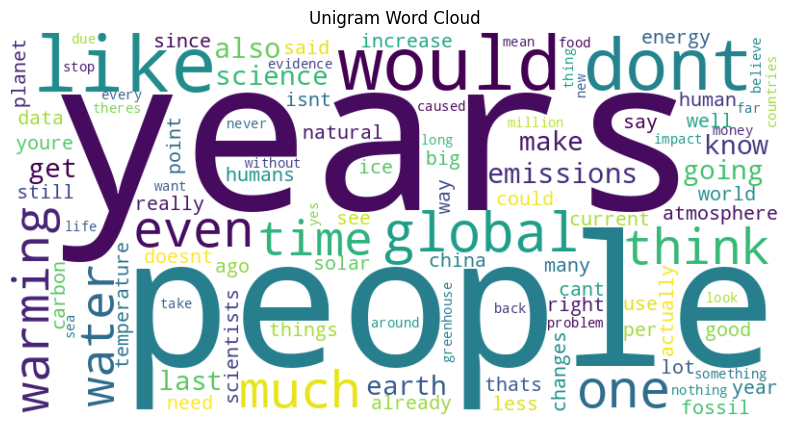


Generating Bigram Word Cloud...
Saved bigram_word_cloud.png


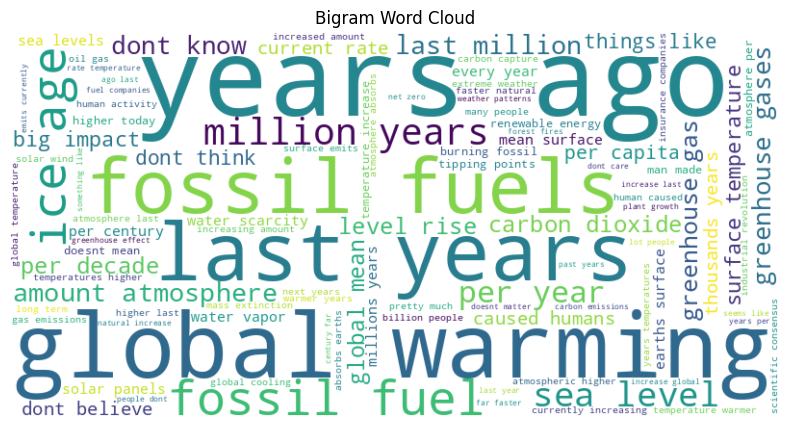


Generating Trigram Word Cloud...
Saved trigram_word_cloud.png


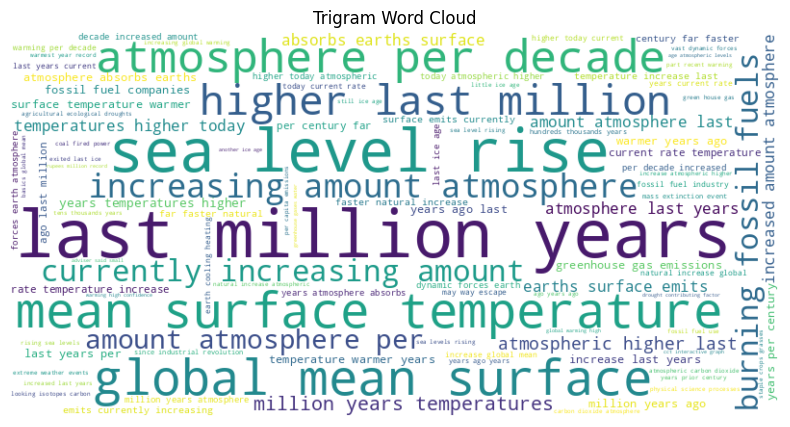

In [3]:
!pip install wordcloud matplotlib

import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import os

# Define file names
unigram_csv = 'reddit_unigrams_all.csv'
bigram_csv = 'reddit_bigrams_all.csv'
trigram_csv = 'reddit_trigrams_all.csv'

# --- Helper function to create and display a word cloud ---
def create_word_cloud(csv_file, output_image_name):
    if not os.path.exists(csv_file):
        print(f"Error: {csv_file} not found. Please run Step 3 first.", file=sys.stderr)
        return

    # Read the CSV and convert to a frequency dictionary
    df = pd.read_csv(csv_file)
    # Take top 100 for a cleaner-looking cloud
    df = df.head(100)
    # Convert to dict: {'word': frequency}
    # Ensure concept is a string
    frequencies = {str(row['concept']): row['frequency'] for index, row in df.iterrows()}

    # Generate the word cloud
    wc = WordCloud(width=800, height=400, background_color='white', collocations=False).generate_from_frequencies(frequencies)

    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.title(output_image_name.replace('_', ' ').title().replace('.Png', ''))
    plt.axis('off')

    # Save the image
    plt.savefig(output_image_name)
    print(f"Saved {output_image_name}")

    # Show the plot
    plt.show()

# --- Generate the three word clouds ---
print("Generating Unigram Word Cloud...")
create_word_cloud(unigram_csv, 'unigram_word_cloud.png')

print("\nGenerating Bigram Word Cloud...")
create_word_cloud(bigram_csv, 'bigram_word_cloud.png')

print("\nGenerating Trigram Word Cloud...")
create_word_cloud(trigram_csv, 'trigram_word_cloud.png')


# Step 5 (UPDATED): Download Your Result Files

Run this final cell to download all seven result files:
* `reddit_unigrams_all.csv`
* `reddit_bigrams_all.csv`
* `reddit_trigrams_all.csv`
* `reddit_triples_all.csv`
* `unigram_word_cloud.png`
* `bigram_word_cloud.png`
* `trigram_word_cloud.png`

**Note:** Your browser may ask for permission to download multiple files.

In [4]:
from google.colab import files
import os

print("Initiating downloads for 7 files...")

files_to_download = [
    'reddit_unigrams_all.csv',
    'reddit_bigrams_all.csv',
    'reddit_trigrams_all.csv',
    'reddit_triples_all.csv',
    'unigram_word_cloud.png',
    'bigram_word_cloud.png',
    'trigram_word_cloud.png'
]

for f in files_to_download:
    if os.path.exists(f):
        files.download(f)
        print(f"Downloading {f}...")
    else:
        print(f"Error: {f} not found. Did you run Step 3 and Step 4 successfully?")

print("\nDownloads complete. Please check your browser.")

Initiating downloads for 7 files...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Downloads complete. Please check your browser.
